Dataset Shape: (22642, 3)
Class distribution in y_train: Counter({5: 10033, 4: 3926, 3: 2258, 2: 1239, 1: 657})
Class distribution after SMOTE: Counter({5: 10033, 1: 10033, 4: 10033, 3: 10033, 2: 10033})
Evaluation for MultinomialNB: {'accuracy': 0.5694413777875911, 'precision': np.float64(0.5996336301579224), 'recall': np.float64(0.5694413777875911), 'f1': np.float64(0.5823564684961346)}
Evaluation for KNeighborsClassifier: {'accuracy': 0.1408699492161625, 'precision': np.float64(0.626293541715244), 'recall': np.float64(0.1408699492161625), 'f1': np.float64(0.09536915395709922)}

Model Evaluation Metrics:
Naive Bayes:
  Accuracy: 0.57
  Precision: 0.60
  Recall: 0.57
  F1: 0.58

KNN:
  Accuracy: 0.14
  Precision: 0.63
  Recall: 0.14
  F1: 0.10


C:\Users\jaya0\AppData\Local\Temp\ipykernel_24696\1705637718.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="plasma")


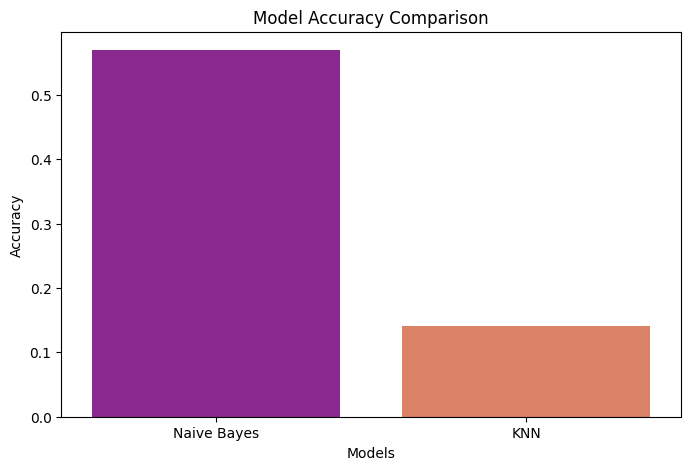

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter


# Tkinter Frontend for Review Classification
class ReviewClassifierApp:
    def __init__(self, root, nb_model, knn_model, vectorizer):
        self.root = root
        self.nb_model = nb_model
        self.knn_model = knn_model
        self.vectorizer = vectorizer

        self.root.title("Review Classifier")

        # Input Section
        self.instruction_label = tk.Label(root, text="Enter a review to classify:")
        self.instruction_label.pack(pady=10)

        self.review_entry = tk.Entry(root, width=50)
        self.review_entry.pack(pady=10)

        self.nb_button = tk.Button(root, text="Classify with Naive Bayes", command=self.classify_with_nb)
        self.nb_button.pack(pady=10)

        self.knn_button = tk.Button(root, text="Classify with KNN", command=self.classify_with_knn)
        self.knn_button.pack(pady=10)

        # Output Section
        self.result_label = tk.Label(root, text="", font=("Helvetica", 14))
        self.result_label.pack(pady=10)

        self.emoji_label = tk.Label(root, text="", font=("Helvetica", 40))
        self.emoji_label.pack(pady=10)

    def classify_with_nb(self):
        self.classify_review(self.nb_model)

    def classify_with_knn(self):
        self.classify_review(self.knn_model)

    def classify_review(self, model):
        review_text = self.review_entry.get()
        if not review_text:
            messagebox.showwarning("Input Error", "Please enter a review.")
            return

        review_vect = self.vectorizer.transform([review_text])
        predicted_class = model.predict(review_vect)[0]
        self.display_result(predicted_class)

    def display_result(self, predicted_class):
        # Map ratings to emojis
        emoji_map = {
            1: "🌑",  # Low rating
            2: "😊",  # Mild smile
            3: "😃",  # Moderate smile
            4: "😄",  # Big smile
            5: "🤩"   # Enthusiastic smile
        }

        # Display prediction and emoji
        self.result_label.config(text=f"Predicted Rating: {predicted_class}", fg="blue")
        self.emoji_label.config(text=emoji_map.get(predicted_class, "😊"))


# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1": f1_score(y_test, y_pred, average="weighted"),
    }

    # Debugging: Print the evaluation metrics
    print(f"Evaluation for {model.__class__.__name__}: {metrics}")
    return metrics


# Function to visualize model comparison
def plot_model_comparison(metrics):
    plt.figure(figsize=(8, 5))
    models = list(metrics.keys())
    accuracies = [metrics[model]["accuracy"] for model in models]

    sns.barplot(x=models, y=accuracies, palette="plasma")
    plt.title("Model Accuracy Comparison")
    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.show()


# Main Function
def main():
    # Load and preprocess data
    file_path = "reviewdataset.csv"
    if not os.path.exists(file_path):
        print("Error: Dataset file not found.")
        return

    fields = ["Title", "Review Text", "Rating"]
    df = pd.read_csv(file_path, usecols=fields)
    
    # Handle missing data
    df["Review Text"] = df["Review Text"].fillna(df["Title"])
    df = df.dropna(subset=["Review Text"])
    
    # Normalize text (convert to lowercase)
    df["Review Text"] = df["Review Text"].str.lower()

    # Debugging: Print dataset shape after cleaning
    print(f"Dataset Shape: {df.shape}")
    
    # Train-test split
    X = df["Review Text"]
    y = df["Rating"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Debugging: Check class distribution in training set
    print(f"Class distribution in y_train: {Counter(y_train)}")
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    # SMOTE for balancing
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vect, y_train)

    # Debugging: Check class distribution after SMOTE
    print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

    # Initialize models
    naive_bayes = MultinomialNB()
    knn = KNeighborsClassifier(n_neighbors=5)

    # Evaluate models
    nb_metrics = evaluate_model(naive_bayes, X_train_resampled, X_test_vect, y_train_resampled, y_test)
    knn_metrics = evaluate_model(knn, X_train_resampled, X_test_vect, y_train_resampled, y_test)

    # Print metrics to console
    print("\nModel Evaluation Metrics:")
    print("Naive Bayes:")
    for metric, value in nb_metrics.items():
        print(f"  {metric.capitalize()}: {value:.2f}")

    print("\nKNN:")
    for metric, value in knn_metrics.items():
        print(f"  {metric.capitalize()}: {value:.2f}")

    # Compare models
    metrics = {"Naive Bayes": nb_metrics, "KNN": knn_metrics}
    plot_model_comparison(metrics)

    # Launch GUI
    root = tk.Tk()
    app = ReviewClassifierApp(root, naive_bayes, knn, vectorizer)
    root.mainloop()


if __name__ == "__main__":
    main()
